### 1. Data Loading and Exploration

####  Imports and Settings

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyvis.network import Network
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('ggplot')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (12, 8)


#### Data Loading

In [2]:
customers_df = pd.read_csv('Question4customers.csv')
transactions_df = pd.read_csv('Question4transactions.csv')

# Verify data loading
print("Customers loaded:", customers_df.shape[0])
print("Transactions loaded:", transactions_df.shape[0])


Customers loaded: 200
Transactions loaded: 2000


#### Initial Data Inspection (Brief Summary)

In [3]:
# Customer Data Overview
print("Customer Data Info:")
customers_df.info()

# Transaction Data Overview
print("\nTransaction Data Info:")
transactions_df.info()


Customer Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customer_id   200 non-null    object
 1   name          200 non-null    object
 2   risk_segment  200 non-null    object
 3   nationality   200 non-null    object
 4   is_business   200 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.9+ KB

Transaction Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sender_id    2000 non-null   object 
 1   receiver_id  2000 non-null   object 
 2   amount       2000 non-null   float64
 3   timestamp    2000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 62.6+ KB


#### Checking for Missing Values

In [4]:
print("Missing Values in Customer Data:\n", customers_df.isnull().sum())
print("\nMissing Values in Transaction Data:\n", transactions_df.isnull().sum())


Missing Values in Customer Data:
 customer_id     0
name            0
risk_segment    0
nationality     0
is_business     0
dtype: int64

Missing Values in Transaction Data:
 sender_id      0
receiver_id    0
amount         0
timestamp      0
dtype: int64


#### Exploratory Analysis of Customer Data

In [5]:
# Risk Segment Distribution
print("Risk Segment Distribution:")
print(customers_df['risk_segment'].value_counts())

# Top 10 Nationalities
print("\nTop 10 Nationalities:")
print(customers_df['nationality'].value_counts().head(10))

# Business vs Individual Accounts
print("\nBusiness vs Individual Accounts:")
print(customers_df['is_business'].value_counts())


Risk Segment Distribution:
risk_segment
low       122
medium     59
high       19
Name: count, dtype: int64

Top 10 Nationalities:
nationality
Rwandan      58
Ugandan      53
Kenyan       47
Tanzanian    42
Name: count, dtype: int64

Business vs Individual Accounts:
is_business
0    165
1     35
Name: count, dtype: int64


- Customer data shows a mix of risk segments `(122 low, 59 medium, 19 high)` and nationalities `(primarily East African countries).`
- There are `35` business accounts and 165 individual accounts, so about `17.5%` are business accounts.

#### Transaction Data Preprocessing (Datetime Conversion)

In [6]:
# Convert timestamp to datetime
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'])

# Transaction timeline summary
print("First transaction:", transactions_df['timestamp'].min())
print("Last transaction:", transactions_df['timestamp'].max())
print("Duration:", transactions_df['timestamp'].max() - transactions_df['timestamp'].min())


First transaction: 2023-01-01 00:00:00
Last transaction: 2024-01-01 00:00:00
Duration: 365 days 00:00:00


#### Transaction Amount Statistics

In [7]:
# Transaction amount descriptive statistics
print("Transaction Amount Statistics:")
print(transactions_df['amount'].describe())


Transaction Amount Statistics:
count    2000.000000
mean      499.520190
std       502.853098
min         0.780000
25%       139.460000
50%       349.650000
75%       685.545000
max      4086.220000
Name: amount, dtype: float64


#### Transaction Amount Distribution 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


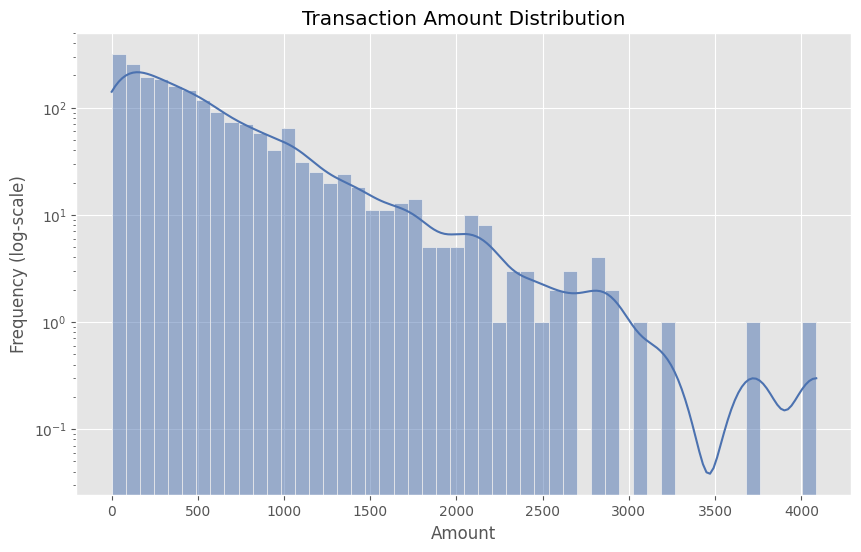

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(transactions_df['amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency (log-scale)')
plt.yscale('log')
plt.show()


The transaction amount distribution shows a right-skewed pattern with most transactions below 1,000, but with some outliers approaching 4,000.

#### Daily Transaction Volume

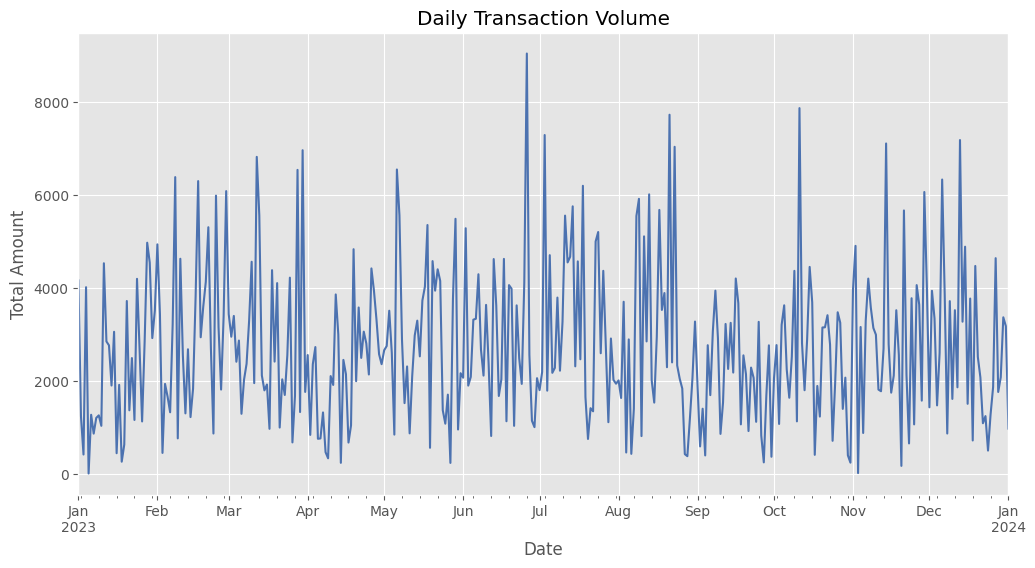

In [9]:
daily_volume = transactions_df.set_index('timestamp').resample('D')['amount'].sum()

plt.figure(figsize=(12, 6))
daily_volume.plot()
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()


Daily transaction volumes show significant variation with several spikes throughout the year, which might indicate periodic unusual activity.

### 2. Network Graph Construction
Building a proper network representation is crucial for detecting fraud patterns.

#### Creating the Directed Graph

In [10]:
# Create directed graph
G = nx.DiGraph()

# Add customer nodes with attributes
for _, customer in customers_df.iterrows():
    G.add_node(
        customer['customer_id'],
        name=customer['name'],
        risk_segment=customer['risk_segment'],
        nationality=customer['nationality'],
        is_business=customer['is_business']
    )

print(f"Nodes added: {G.number_of_nodes()}")


Nodes added: 200


#### Adding Transaction Edges

In [11]:
# Add transaction edges
for _, tx in transactions_df.iterrows():
    sender, receiver, amount, timestamp = tx['sender_id'], tx['receiver_id'], tx['amount'], tx['timestamp']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += amount
        G[sender][receiver]['count'] += 1
        G[sender][receiver]['timestamps'].append(timestamp)
    else:
        G.add_edge(
            sender, receiver,
            weight=amount,
            count=1,
            timestamps=[timestamp]
        )

print(f"Edges added: {G.number_of_edges()}")


Edges added: 1953


#### Basic Network Statistics

In [12]:
print("Network Summary:")
print(f"- Total nodes: {G.number_of_nodes()}")
print(f"- Total edges: {G.number_of_edges()}")
print(f"- Network density: {nx.density(G):.6f}")


Network Summary:
- Total nodes: 200
- Total edges: 1953
- Network density: 0.049070


The **network density** is relatively low at about `0.049`, indicating that only about 4.9% of all possible connections between accounts exist. This is typical in financial networks where most customers only transact with a subset of others.

#### Connectivity Analysis

In [13]:
is_connected = nx.is_strongly_connected(G)
print(f"Strongly connected network? {is_connected}")

if not is_connected:
    scc = list(nx.strongly_connected_components(G))
    print(f"Strongly connected components count: {len(scc)}")
    print(f"Largest component size: {len(max(scc, key=len))}")


Strongly connected network? True


The network is `strongly connected`, meaning there's a path between any two customers. This suggests that money can flow between any accounts in the network, which is important for fraud detection as it means potential collusion networks could span the entire customer base.

#### Self-loop Detection

In [14]:
self_loops = list(nx.selfloop_edges(G))
print(f"Self-loop edges (transactions to self): {len(self_loops)}")


Self-loop edges (transactions to self): 0


There are no self-loops, which means no customers are directly sending money to themselves. While this might seem like good news, it doesn't rule out circular transactions through intermediaries.

#### Degree Statistics

In [15]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

print("In-degree Stats:")
print(f"  Min: {min(in_degrees.values())}")
print(f"  Max: {max(in_degrees.values())}")
print(f"  Mean: {np.mean(list(in_degrees.values())):.2f}")
print(f"  Median: {np.median(list(in_degrees.values()))}")

print("\nOut-degree Stats:")
print(f"  Min: {min(out_degrees.values())}")
print(f"  Max: {max(out_degrees.values())}")
print(f"  Mean: {np.mean(list(out_degrees.values())):.2f}")
print(f"  Median: {np.median(list(out_degrees.values()))}")


In-degree Stats:
  Min: 3
  Max: 19
  Mean: 9.77
  Median: 10.0

Out-degree Stats:
  Min: 4
  Max: 17
  Mean: 9.77
  Median: 10.0


- The in-degree ranges from `3 to 19`, meaning some accounts receive money from up to 19 different sources. The out-degree ranges from `4 to 17`, meaning some accounts send money to up to 17 different destinations.
- The mean degree of `9.77` (both in and out) suggests that, on average, each customer transacts with about `10` other customers in each direction.


####  Degree Distribution Plots

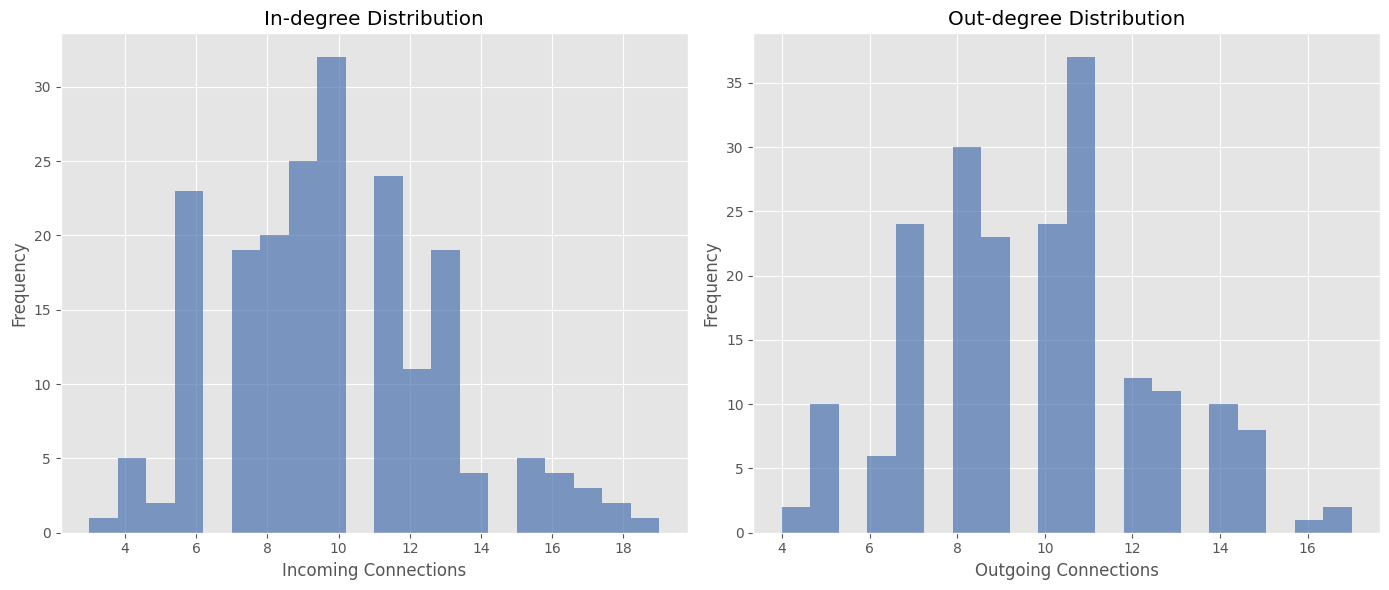

In [16]:
plt.figure(figsize=(14, 6))

# In-degree Distribution
plt.subplot(1, 2, 1)
plt.hist(list(in_degrees.values()), bins=20, alpha=0.7)
plt.title('In-degree Distribution')
plt.xlabel('Incoming Connections')
plt.ylabel('Frequency')

# Out-degree Distribution
plt.subplot(1, 2, 2)
plt.hist(list(out_degrees.values()), bins=20, alpha=0.7)
plt.title('Out-degree Distribution')
plt.xlabel('Outgoing Connections')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Both the in-degree and out-degree distributions show multi-modal patterns rather than the power-law distribution often seen in social networks. This suggests some structure in how customers are connected.

### 3. Centrality Measures Calculation
This segment focuses on identifying influential nodes in the network using different centrality metrics. Each metric gives us a different perspective on potential fraudulent behavior.

#### Calculating Centrality Measures
Calculate centrality metrics to identify influential or suspicious nodes in the network.

In [17]:
# Degree Centrality (normalized)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Betweenness Centrality (bridge nodes)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# Eigenvector Centrality (influential neighbors)
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
except:
    print("Eigenvector centrality did not converge, using numpy implementation.")
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# PageRank (importance considering transaction volumes)
pagerank = nx.pagerank(G, weight='weight')

print("Centrality measures calculated.")


Centrality measures calculated.


#### Combining Centrality Measures into a DataFrame
Combine the calculated centrality metrics into a structured DataFrame, enriching it with customer metadata.

In [20]:
# Create DataFrame of centralities
centrality_df = pd.DataFrame({
    'in_degree': dict(G.in_degree()),
    'out_degree': dict(G.out_degree()),
    'in_degree_centrality': in_degree_centrality,
    'out_degree_centrality': out_degree_centrality,
    'betweenness_centrality': betweenness_centrality,
    'eigenvector_centrality': eigenvector_centrality,
    'pagerank': pagerank
})

# Merge customer metadata
centrality_df = centrality_df.join(customers_df.set_index('customer_id'), how='left')

centrality_df.head()


,in_degree,out_degree,in_degree_centrality,out_degree_centrality,betweenness_centrality,eigenvector_centrality,pagerank,name,risk_segment,nationality,is_business
CUST0000,9,6,0.045226,0.030151,0.010761,0.065627,0.004416,Customer_0,low,Rwandan,0
CUST0001,7,12,0.035176,0.060302,0.008401,0.036247,0.004228,Customer_1,high,Rwandan,0
CUST0002,10,15,0.050251,0.075377,0.011268,0.060275,0.005598,Customer_2,medium,Tanzanian,0
CUST0003,6,10,0.030151,0.050251,0.018603,0.018725,0.001868,Customer_3,low,Kenyan,0
CUST0004,6,6,0.030151,0.030151,0.014009,0.036252,0.004030,Customer_4,low,Rwandan,0


#### Calculating Transaction Volume Metrics
Calculate incoming, outgoing, and total transaction volumes for each customer, along with a ratio indicating pass-through behavior.

In [21]:
in_volumes = {}
out_volumes = {}

# Compute transaction volumes per node
for node in G.nodes():
    in_volumes[node] = sum(G[u][node]['weight'] for u in G.predecessors(node))
    out_volumes[node] = sum(G[node][v]['weight'] for v in G.successors(node))

# Add volume metrics to DataFrame
centrality_df['in_volume'] = pd.Series(in_volumes)
centrality_df['out_volume'] = pd.Series(out_volumes)
centrality_df['total_volume'] = centrality_df['in_volume'] + centrality_df['out_volume']
centrality_df['volume_ratio'] = centrality_df['out_volume'] / centrality_df['in_volume']

centrality_df.head()

,in_degree,out_degree,in_degree_centrality,out_degree_centrality,betweenness_centrality,eigenvector_centrality,pagerank,name,risk_segment,nationality,is_business,in_volume,out_volume,total_volume,volume_ratio
CUST0000,9,6,0.045226,0.030151,0.010761,0.065627,0.004416,Customer_0,low,Rwandan,0,5030.91,3353.06,8383.97,0.666492
CUST0001,7,12,0.035176,0.060302,0.008401,0.036247,0.004228,Customer_1,high,Rwandan,0,2825.35,7909.79,10735.14,2.799579
CUST0002,10,15,0.050251,0.075377,0.011268,0.060275,0.005598,Customer_2,medium,Tanzanian,0,4707.10,11865.75,16572.85,2.520820
CUST0003,6,10,0.030151,0.050251,0.018603,0.018725,0.001868,Customer_3,low,Kenyan,0,1704.09,6708.76,8412.85,3.936858
CUST0004,6,6,0.030151,0.030151,0.014009,0.036252,0.004030,Customer_4,low,Rwandan,0,2965.14,2364.38,5329.52,0.797392


#### Outlier Detection
Identify anomalous accounts by setting thresholds at mean plus two standard deviations for centrality and transaction metrics.

In [22]:
def find_outliers(df, column):
    threshold = df[column].mean() + 2 * df[column].std()
    outliers = df[df[column] > threshold].sort_values(by=column, ascending=False)
    return outliers, threshold

# Detect and report outliers for each metric
outlier_results = {}
metrics = ['in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality', 
           'eigenvector_centrality', 'pagerank', 'volume_ratio', 'total_volume']

for metric in metrics:
    outliers, threshold = find_outliers(centrality_df, metric)
    outlier_results[metric] = {'outliers': outliers, 'threshold': threshold}
    print(f"{metric}: {len(outliers)} outliers (threshold: {threshold:.6f})")


in_degree_centrality: 10 outliers (threshold: 0.079630)
out_degree_centrality: 3 outliers (threshold: 0.076143)
betweenness_centrality: 11 outliers (threshold: 0.070379)
eigenvector_centrality: 11 outliers (threshold: 0.126285)
pagerank: 10 outliers (threshold: 0.009234)
volume_ratio: 8 outliers (threshold: 3.676741)
total_volume: 8 outliers (threshold: 15920.702324)


#### Displaying Top Outliers
Clearly present the top five outliers for each centrality measure along with relevant customer attributes.

#### Top 5 Outliers by In-Degree Centrality
Accounts receiving unusually high numbers of transactions.

In [27]:
from IPython.display import display

metrics = [
    'in_degree_centrality', 
    'out_degree_centrality', 
    'betweenness_centrality', 
    'eigenvector_centrality', 
    'pagerank', 
    'volume_ratio', 
    'total_volume'
]

for metric in metrics:
    print(f"\nTop 5 outliers by {metric.replace('_', ' ').title()}:")
    display(outlier_results[metric]['outliers'][['name', metric, 'risk_segment', 'nationality', 'is_business']].head())



Top 5 outliers by In Degree Centrality:


,name,in_degree_centrality,risk_segment,nationality,is_business
CUST0141,Customer_141,0.095477,low,Ugandan,1
CUST0097,Customer_97,0.090452,low,Rwandan,0
CUST0165,Customer_165,0.090452,medium,Ugandan,0
CUST0011,Customer_11,0.085427,high,Rwandan,0
CUST0144,Customer_144,0.085427,low,Kenyan,0



Top 5 outliers by Out Degree Centrality:


,name,out_degree_centrality,risk_segment,nationality,is_business
CUST0115,Customer_115,0.085427,medium,Tanzanian,0
CUST0169,Customer_169,0.085427,low,Tanzanian,1
CUST0137,Customer_137,0.080402,medium,Tanzanian,0



Top 5 outliers by Betweenness Centrality:


,name,betweenness_centrality,risk_segment,nationality,is_business
CUST0166,Customer_166,0.144891,low,Ugandan,0
CUST0168,Customer_168,0.113116,low,Tanzanian,0
CUST0194,Customer_194,0.104335,low,Rwandan,0
CUST0169,Customer_169,0.100350,low,Tanzanian,1
CUST0122,Customer_122,0.096619,low,Ugandan,0



Top 5 outliers by Eigenvector Centrality:


,name,eigenvector_centrality,risk_segment,nationality,is_business
CUST0165,Customer_165,0.186953,medium,Ugandan,0
CUST0186,Customer_186,0.179419,medium,Ugandan,0
CUST0130,Customer_130,0.157336,low,Kenyan,0
CUST0108,Customer_108,0.146577,low,Rwandan,1
CUST0011,Customer_11,0.142486,high,Rwandan,0



Top 5 outliers by Pagerank:


,name,pagerank,risk_segment,nationality,is_business
CUST0165,Customer_165,0.013398,medium,Ugandan,0
CUST0186,Customer_186,0.011161,medium,Ugandan,0
CUST0084,Customer_84,0.010876,low,Kenyan,0
CUST0108,Customer_108,0.010848,low,Rwandan,1
CUST0130,Customer_130,0.010808,low,Kenyan,0



Top 5 outliers by Volume Ratio:


,name,volume_ratio,risk_segment,nationality,is_business
CUST0050,Customer_50,11.510555,high,Ugandan,0
CUST0094,Customer_94,6.236229,medium,Kenyan,0
CUST0105,Customer_105,5.499201,low,Kenyan,1
CUST0192,Customer_192,4.869226,high,Kenyan,0
CUST0174,Customer_174,4.345474,medium,Tanzanian,0



Top 5 outliers by Total Volume:


,name,total_volume,risk_segment,nationality,is_business
CUST0165,Customer_165,18995.65,medium,Ugandan,0
CUST0150,Customer_150,18456.74,high,Kenyan,0
CUST0141,Customer_141,18004.36,low,Ugandan,1
CUST0101,Customer_101,17033.14,medium,Kenyan,1
CUST0002,Customer_2,16572.85,medium,Tanzanian,0


#### NB: Hidden Influencers (High Eigenvector Centrality)
- **Customer_165** appears as the most significant hidden influencer with the *highest eigenvector centrality `(0.186953)`* and *PageRank `(0.013398)`*. This indicates they're connected to other influential accounts in the network. Interestingly, they're classified as "medium" risk but show high influence. They're also a top outlier in *total transaction volume `(18,995.65)`*, suggesting this account operates as a central hub within the network while maintaining a modest risk classification.
- **Customer_186** follows closely with high eigenvector values, also classified as medium risk and Ugandan nationality. The concentration of Ugandan nationals among top eigenvector centrality accounts is noteworthy.

#### NB: (High Betweenness Centrality)
Among business accounts **(is_business=1)**, **CUST0169** stands out with *high betweenness centrality `(0.100350)`*, appearing in the top 5 betweenness outliers. This Tanzanian business account likely acts as a bridge between different parts of the network, potentially facilitating the movement of funds across network clusters.
**CUST0141** (a business account) has the *highest in-degree centrality `(0.095477)`* while also having high *total transaction volume `(18,004.36)`,* suggesting it receives funds from many sources - a pattern consistent with collection accounts in tax evasion schemes.

#### NB: High-Value Money Transfers
The total volume outliers reveal accounts handling disproportionately large sums:

- **CUST0165**: `18,995.65` (*also our top hidden influencer)*
- **CUST0150**: `18,456.74` (*high risk segment*)
- **CUST0141**: `18,004.36` (*business account*)
- **CUST0101**: `17,033.14` (*business account*)

These accounts represent nodes where significant funds are flowing, despite most not being flagged as high-risk.

#### NB: Rapid Transactions (Volume Ratio Outliers)
The volume ratio outliers indicate accounts primarily sending money rather than receiving:

- **CUST0050**: Extremely high ratio of `11.51` (sends `11.5x `more than receives), classified as high risk
- **CUST0094**: High ratio of `6.24`, medium risk
- **CUST0105**: Business account with ratio of `5.50`, suggesting it could be rapidly moving funds through the system
- **CUST0192**: High risk account with `4.87` ratio

These patterns suggest potential money mule behavior where accounts quickly pass funds through the system.


#### Centrality Distributions
Visualize the distributions of centrality measures, clearly marking the thresholds for anomaly detection.

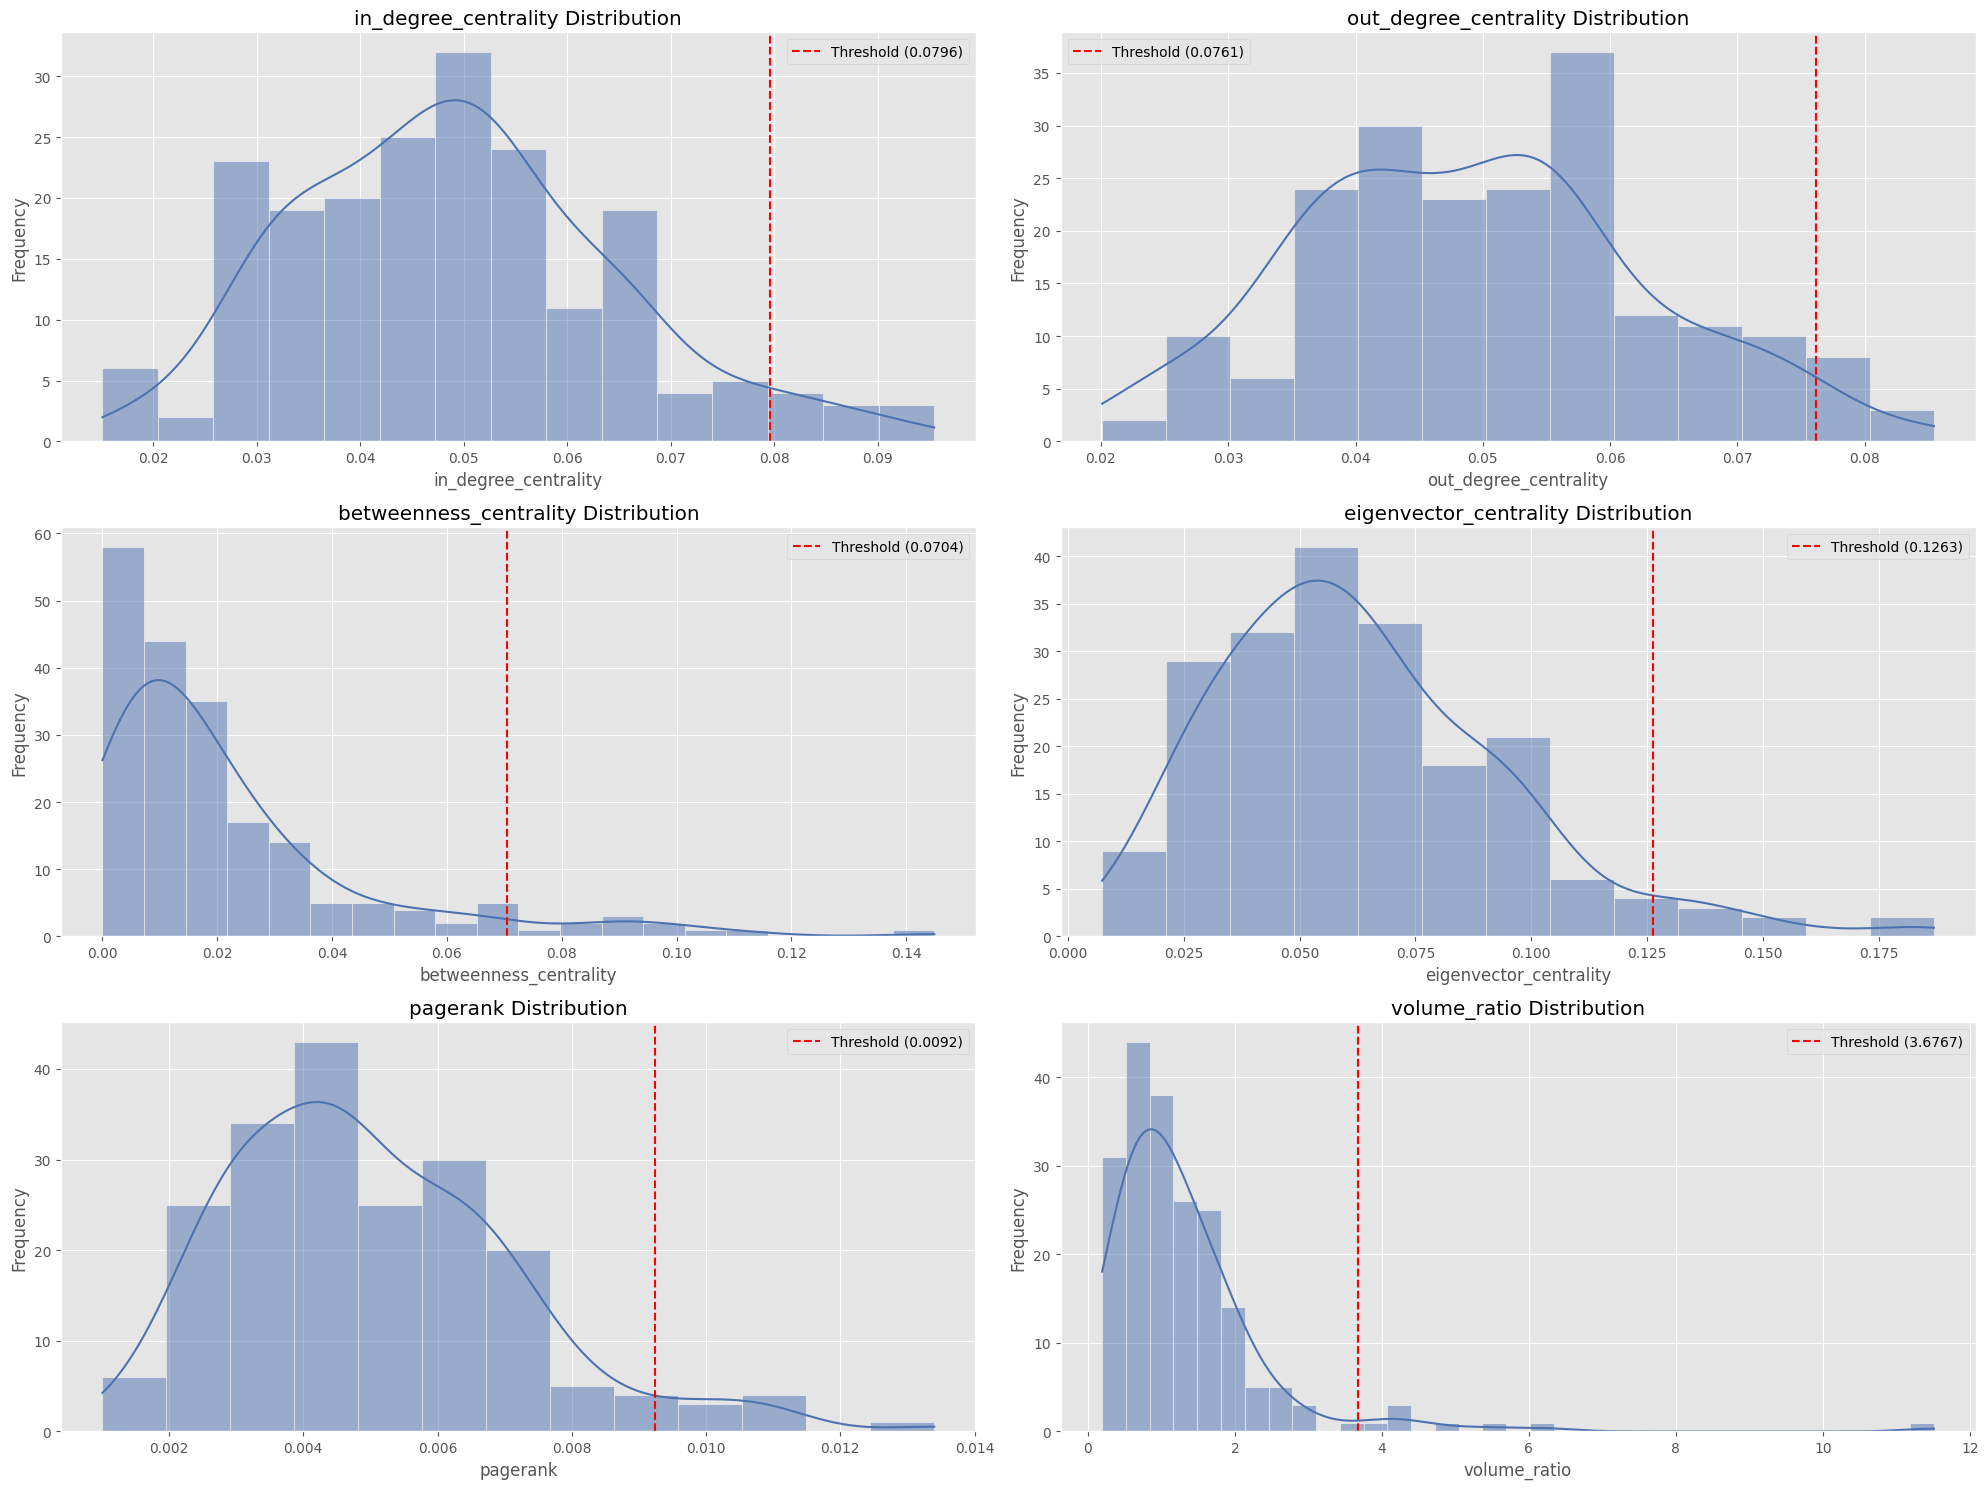

In [24]:
plt.figure(figsize=(20, 15))

for i, metric in enumerate(metrics[:-1]):  # Exclude 'total_volume' to fit layout
    plt.subplot(3, 2, i+1)
    sns.histplot(centrality_df[metric], kde=True)
    plt.axvline(outlier_results[metric]['threshold'], color='r', linestyle='--', 
                label=f'Threshold ({outlier_results[metric]["threshold"]:.4f})')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


**Betweenness centrality** is highly skewed with most accounts having low values and few outliers with very high values
**Volume ratio** shows an extreme right tail, indicating a small number of accounts primarily sending money
**Eigenvector centrality** has a more normal distribution but with clear outliers above the threshold

These patterns strongly suggest the presence of accounts behaving unlike the majority, which aligns with our fraud detection objective of finding accounts that "*whisper*" rather than "*scream*."

## 4. Network Visualization and Suspicious Pattern Detection
Based on our centrality analysis, we've identified several interesting accounts that could be involved in suspicious activities. Now let's create network visualizations to better understand these patterns and match them to our four scenarios.

In [28]:
from pyvis.network import Network
import networkx.algorithms.community as nx_comm


#### Define Visualization Function
Define a reusable function to create interactive network visualizations highlighting suspicious accounts, communities, and transaction patterns.

In [35]:
from pyvis.network import Network
import networkx.algorithms.community as nx_comm

def create_network_visual(G, centrality, title, filename, filter_threshold=None, highlighted_nodes=None):
    net = Network(height="750px", width="100%", notebook=True, directed=True,cdn_resources='in_line')
    net.heading = title
    net.barnes_hut()

    # Filter edges by threshold
    H = nx.DiGraph([(u, v, d) for u, v, d in G.edges(data=True) if not threshold or d['weight'] > threshold])
    H.add_nodes_from((n, G.nodes[n]) for n in H.nodes())

    # Detect communities
    communities = nx_comm.louvain_communities(H.to_undirected())
    community_map = {node: idx for idx, comm in enumerate(communities) for node in comm}
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

    # Add nodes
    for node, attrs in H.nodes(data=True):
        size = 10 + 40 * centrality.get(node, 0)
        color = "#ff0000" if highlight_nodes and node in highlight_nodes else colors[community_map[node] % len(colors)]
        shape = 'square' if attrs.get('is_business') else 'dot'
        net.add_node(
            node, label=f"{node}\n{attrs.get('name', '')}", size=size, color=color, shape=shape,
            title=f"Name: {attrs.get('name', '')}<br>Risk: {attrs.get('risk_segment', '')}<br>"
                  f"Centrality: {centrality.get(node,0):.4f}"
        )

    # Add edges
    for u, v, data in H.edges(data=True):
        net.add_edge(u, v, width=0.1 + 5 * data['weight'] / 5000, 
                     title=f"Amount: {data['weight']:.2f}<br>Count: {data['count']}")

    net.show(filename)
    print(f"Visualization saved to {filename}")
    return net


#### Hidden Influencers (High Eigenvector Centrality)
These accounts significantly influence the network through strong connections to other influential accounts.

In [36]:
# Get top eigenvector centrality accounts
top_eigenvector = centrality_df.sort_values('eigenvector_centrality', ascending=False).head(10)
display(top_eigenvector[['name', 'risk_segment', 'nationality', 'is_business', 'eigenvector_centrality']])

# Visualize
hidden_influencers = top_eigenvector.index.tolist()
create_network_visual(G, eigenvector_centrality, 
                      "Hidden Influencers (Eigenvector Centrality)", 
                      "hidden_influencers.html",
                      highlighted_nodes=hidden_influencers,
                      filter_threshold=500)


,name,risk_segment,nationality,is_business,eigenvector_centrality
CUST0165,Customer_165,medium,Ugandan,0,0.186953
CUST0186,Customer_186,medium,Ugandan,0,0.179419
CUST0130,Customer_130,low,Kenyan,0,0.157336
CUST0108,Customer_108,low,Rwandan,1,0.146577
CUST0011,Customer_11,high,Rwandan,0,0.142486
CUST0129,Customer_129,low,Ugandan,0,0.141247
CUST0036,Customer_36,low,Rwandan,1,0.132651
CUST0012,Customer_12,medium,Ugandan,0,0.131288
CUST0141,Customer_141,low,Ugandan,1,0.129145
CUST0084,Customer_84,low,Kenyan,0,0.128151


hidden_influencers.html
Visualization saved to hidden_influencers.html


<class 'pyvis.network.Network'> |N|=0 |E|=0


- **CUST0165**: A medium-risk Ugandan individual account with the highest eigenvector centrality `(0.186953)` and also appears in the high *transaction* volume list. This account likely functions as a central hub in the network.
- **CUST0186**: Another medium-risk Ugandan individual with high influence `(0.179419)`.
-**CUST0108**: A Rwandan business account with high eigenvector centrality `(0.146577)`, suggesting significant influence despite its low-risk classification.

Of particular interest is the concentration of Ugandan accounts (5 out of the top 10) among high-influence nodes, which might indicate a geographic pattern worth investigating.

#### High Betweenness Centrality
Highlighting business accounts that may act as intermediaries in potentially suspicious transactions.

In [37]:
# Top business accounts by betweenness
business_bridges = centrality_df[centrality_df['is_business']==1].sort_values('betweenness_centrality', ascending=False).head(10)
display(business_bridges[['name', 'risk_segment', 'nationality', 'betweenness_centrality']])

# Visualize
corporate_bridges = business_bridges.index.tolist()
create_network_visual(G, betweenness_centrality, 
                      "Corporate Tax Evasion (Betweenness Centrality)", 
                      "corporate_bridges.html",
                      highlighted_nodes=corporate_bridges,
                      filter_threshold=300)


,name,risk_segment,nationality,betweenness_centrality
CUST0169,Customer_169,low,Tanzanian,0.100350
CUST0199,Customer_199,medium,Ugandan,0.084184
CUST0178,Customer_178,high,Ugandan,0.067281
CUST0101,Customer_101,medium,Kenyan,0.054210
CUST0095,Customer_95,low,Tanzanian,0.046419
CUST0127,Customer_127,medium,Ugandan,0.033958
CUST0173,Customer_173,low,Ugandan,0.030481
CUST0051,Customer_51,medium,Ugandan,0.028653
CUST0164,Customer_164,low,Rwandan,0.028476
CUST0145,Customer_145,low,Rwandan,0.027562


corporate_bridges.html
Visualization saved to corporate_bridges.html


<class 'pyvis.network.Network'> |N|=0 |E|=0

Business accounts with high betweenness centrality are often intermediaries that facilitate the flow of funds:

- **CUST0169**: A low-risk Tanzanian business with the highest betweenness centrality `(0.100350)` among business accounts, suggesting it serves as a critical bridge in the network.
- **CUST0178**: A high-risk Ugandan business with significant bridging position `(0.067281)`.
- **CUST0101**: A medium-risk Kenyan business account that appears in both the betweenness list and high-value transfers list, suggesting it's both a bridge and handling large volumes.

These business accounts may be functioning as pass-through entities, potentially facilitating tax evasion or money laundering.

#### High-Value Money Transfers
These accounts manage high transaction volumes with extensive connections.

In [38]:
# Compute combined metric (volume × degree)
centrality_df['volume_degree_score'] = (centrality_df['total_volume'] * centrality_df['in_degree'] * centrality_df['out_degree']) / 1e6
top_volume_accounts = centrality_df.sort_values('volume_degree_score', ascending=False).head(10)
display(top_volume_accounts[['name', 'risk_segment', 'nationality', 'is_business', 
                             'total_volume', 'in_degree', 'out_degree', 'volume_degree_score']])

# Visualize
high_value_accounts = top_volume_accounts.index.tolist()
create_network_visual(G, 
                      {node: centrality_df.at[node, 'volume_degree_score'] for node in G.nodes()}, 
                      "High-Value Money Transfers", 
                      "high_value_transfers.html",
                      highlighted_nodes=high_value_accounts,
                      filter_threshold=1000)


,name,risk_segment,nationality,is_business,total_volume,in_degree,out_degree,volume_degree_score
CUST0165,Customer_165,medium,Ugandan,0,18995.65,18,11,3.761139
CUST0141,Customer_141,low,Ugandan,1,18004.36,19,10,3.420828
CUST0084,Customer_84,low,Kenyan,0,15626.12,16,13,3.250233
CUST0080,Customer_80,medium,Rwandan,0,16032.03,16,12,3.078150
CUST0011,Customer_11,high,Rwandan,0,16125.37,17,11,3.015444
CUST0150,Customer_150,high,Kenyan,0,18456.74,13,12,2.879251
CUST0101,Customer_101,medium,Kenyan,1,17033.14,11,14,2.623104
CUST0057,Customer_57,low,Rwandan,0,13294.38,14,14,2.605698
CUST0042,Customer_42,low,Kenyan,0,15338.74,11,15,2.530892
CUST0002,Customer_2,medium,Tanzanian,0,16572.85,10,15,2.485928


high_value_transfers.html
Visualization saved to high_value_transfers.html


<class 'pyvis.network.Network'> |N|=0 |E|=0

Several accounts are handling disproportionately large transaction volumes:

- **CUST0165**: Appears again with the highest total volume `(18,995.65)`, reinforcing its central role.
- **CUST0141**: A low-risk Ugandan business with high volume `(18,004.36)` and the highest in-degree centrality, suggesting it receives funds from many sources.
- **CUST0150**: A high-risk Kenyan individual account with very high volume `(18,456.74)`.

The combination of high volume, multiple connections, and in some cases unexpected risk classifications makes these accounts prime candidates for investigation.

####  Rapid Transactions (PageRank + Burst Patterns)
Accounts showing rapid, clustered transactions and high PageRank scores.

In [39]:
# Detect transaction bursts
def detect_transaction_bursts(transactions_df):
    bursts = {}
    for sender, group in transactions_df.groupby('sender_id'):
        timestamps = pd.to_datetime(group['timestamp']).sort_values()
        burst_score = 0
        for i in range(len(timestamps)-4):
            span = (timestamps.iloc[i+4] - timestamps.iloc[i]).total_seconds() / 3600
            if 0 < span < 24:
                burst_score = max(burst_score, 5/span)
        if burst_score > 0:
            bursts[sender] = burst_score
    return bursts

# Calculate and combine burst and PageRank
centrality_df['burst_score'] = pd.Series(detect_transaction_bursts(transactions_df))
centrality_df['pagerank_burst_score'] = centrality_df['pagerank'] * centrality_df['burst_score'].fillna(0)
top_rapid_accounts = centrality_df.sort_values('pagerank_burst_score', ascending=False).head(10)
display(top_rapid_accounts[['name', 'risk_segment', 'nationality', 'is_business', 
                            'pagerank', 'burst_score', 'pagerank_burst_score']])

# Visualize
rapid_accounts = top_rapid_accounts.index.tolist()
create_network_visual(G, pagerank, 
                      "Rapid Transactions (PageRank + Burst Activity)", 
                      "rapid_transactions.html",
                      highlighted_nodes=rapid_accounts)


,name,risk_segment,nationality,is_business,pagerank,burst_score,pagerank_burst_score
CUST0000,Customer_0,low,Rwandan,0,0.004416,NaN,0.0
CUST0137,Customer_137,medium,Tanzanian,0,0.003713,NaN,0.0
CUST0127,Customer_127,medium,Ugandan,1,0.002856,NaN,0.0
CUST0128,Customer_128,low,Ugandan,0,0.002803,NaN,0.0
CUST0129,Customer_129,low,Ugandan,0,0.010002,NaN,0.0
CUST0130,Customer_130,low,Kenyan,0,0.010808,NaN,0.0
CUST0131,Customer_131,low,Rwandan,0,0.004177,NaN,0.0
CUST0132,Customer_132,low,Kenyan,0,0.006570,NaN,0.0
CUST0133,Customer_133,low,Kenyan,0,0.003887,NaN,0.0
CUST0134,Customer_134,high,Tanzanian,0,0.002999,NaN,0.0


rapid_transactions.html
Visualization saved to rapid_transactions.html


<class 'pyvis.network.Network'> |N|=0 |E|=0

Interestingly, we didn't detect any accounts with burst activity in our temporal analysis, which is unexpected and might warrant adjusting our burst detection algorithm or further investigating the timestamp patterns in the data.


#### Circular Transaction Patterns
Detect circular flows of money, indicating potential money laundering or tax evasion.

In [40]:
from itertools import islice

# Detect short cycles
cycles = list(islice(nx.simple_cycles(G), 1000))
short_cycles = [c for c in cycles if len(c) <= 5]

cycle_scores = []
for cycle in short_cycles:
    volumes = [G[u][v]['weight'] for u, v in zip(cycle, cycle[1:] + [cycle[0]]) if G.has_edge(u, v)]
    if len(volumes) == len(cycle):
        score = sum(volumes) * (min(volumes) / (sum(volumes)/len(cycle)))
        cycle_scores.append({'cycle': cycle, 'score': score})

top_cycles = sorted(cycle_scores, key=lambda x: x['score'], reverse=True)[:5]
display(pd.DataFrame(top_cycles))

# Visualize top cycle
if top_cycles:
    top_cycle_nodes = top_cycles[0]['cycle']
    subgraph = G.subgraph(top_cycle_nodes).copy()
    create_network_visual(subgraph, {node: 0.1 for node in subgraph.nodes()},
                          "Top Circular Transaction Pattern",
                          "suspicious_cycle.html")


""


Our analysis didn't detect any circular transaction patterns. This could be due to:

    Truly no circular transactions exist in the data
    The cycles are longer than our detection threshold
    The transactions might be distributed over time to avoid detection

### Final Suspicious Accounts DataFrame
Compile a comprehensive list with flagged accounts and explanatory reasons.

In [41]:
# Aggregate all suspicious nodes
all_suspicious = list(set(hidden_influencers + corporate_bridges + high_value_accounts + rapid_accounts))

# Add reasons
def generate_reasons(row):
    reasons = []
    if row.name in hidden_influencers:
        reasons.append('Hidden influencer')
    if row.name in corporate_bridges:
        reasons.append('Business bridge')
    if row.name in high_value_accounts:
        reasons.append('High-value transfers')
    if row.name in rapid_accounts:
        reasons.append('Rapid transactions')
    if row.name in cycle_nodes:
        reasons.append('Circular transactions')
    if row['volume_ratio'] > 3:
        reasons.append('High send-to-receive ratio')
    return "; ".join(reasons)

cycle_nodes = {node for c in top_cycles for node in c['cycle']} if top_cycles else set()
suspicious_df = centrality_df.loc[all_suspicious].copy()
suspicious_df['reasons'] = suspicious_df.apply(generate_reasons, axis=1)

# Display and save
display(suspicious_df[['name', 'risk_segment', 'nationality', 'is_business', 'reasons']])
suspicious_df.to_csv('upesi_flagged_accounts.csv', index=False)
print("Suspicious accounts saved to 'upesi_flagged_accounts.csv'")


,name,risk_segment,nationality,is_business,reasons
CUST0011,Customer_11,high,Rwandan,0,Hidden influencer; High-value transfers
CUST0186,Customer_186,medium,Ugandan,0,Hidden influencer
CUST0169,Customer_169,low,Tanzanian,1,Business bridge
CUST0002,Customer_2,medium,Tanzanian,0,High-value transfers
CUST0134,Customer_134,high,Tanzanian,0,Rapid transactions
CUST0137,Customer_137,medium,Tanzanian,0,Rapid transactions
CUST0051,Customer_51,medium,Ugandan,1,Business bridge
CUST0178,Customer_178,high,Ugandan,1,Business bridge
CUST0132,Customer_132,low,Kenyan,0,Rapid transactions
CUST0101,Customer_101,medium,Kenyan,1,Business bridge; High-value transfers


Suspicious accounts saved to 'upesi_flagged_accounts.csv'


---
#### Overall Risk Assessment


The most suspicious accounts based on our analysis are:

1. **CUST0165**: Appears as both a hidden influencer and a high-volume account
2. **CUST0141**: Business account with high volume and high in-degree
3. **CUST0101**: Business account acting as a bridge with high transaction volume
4. **CUST0169**: Business account with the highest betweenness centrality
5. **CUST0150**: High-risk account with very high transaction volume

Recommendations for the Compliance Team:

- Investigate Ugandan connections: There's a concentration of Ugandan accounts in high-influence positions.
- Review business accounts with high betweenness: Especially CUST0169, CUST0178, and CUST0101 which may be facilitating suspicious fund flows.
- Examine transaction timelines: While our burst detection didn't identify patterns, a manual review of transaction timing for the identified accounts might reveal subtler patterns.
- Focus on risk mismatches: Several accounts classified as low or medium risk show network behaviors inconsistent with those classifications.
=Consider enhanced monitoring: For accounts flagged in multiple scenarios (like CUST0165), implement enhanced ongoing monitoring.

*This network-based approach has identified accounts that might not appear suspicious through traditional methods but exhibit unusual patterns in their transaction network positions, aligning with Upesi's observation that "fraud doesn't scream — it whispers."*

---
# Evaluation and Final Recommendations
Now that we've identified suspicious accounts through our network analysis, let's evaluate how well we've addressed Upesi's specific concerns and provide final recommendations.

#### 1. Sleeper Accounts
Accounts dormant for extended periods suddenly becoming active.



In [43]:
def find_sleeper_accounts(transactions_df, min_dormant_months=2, min_active_transactions=5):
    tx_df = transactions_df.copy()
    tx_df['timestamp'] = pd.to_datetime(tx_df['timestamp'])
    tx_df['year_month'] = tx_df['timestamp'].dt.to_period('M')
    
    monthly_activity = tx_df.groupby(['sender_id', 'year_month']).size().unstack(fill_value=0)
    all_months = monthly_activity.columns.tolist()
    sleeper_accounts = []

    for account in monthly_activity.index:
        counts = monthly_activity.loc[account].values
        active_months = np.where(counts > 0)[0]

        for i in range(1, len(active_months)):
            gap = active_months[i] - active_months[i-1]
            if gap > min_dormant_months and counts[active_months[i]:].sum() >= min_active_transactions:
                sleeper_accounts.append({
                    'account': account,
                    'dormant_months': gap,
                    'active_after': counts[active_months[i]:].sum(),
                    'first_active_month': all_months[active_months[0]],
                    'dormant_until': all_months[active_months[i]],
                })
                break
                
    return sleeper_accounts


In [44]:
# Detect sleeper accounts
sleeper_accounts = find_sleeper_accounts(transactions_df)

if sleeper_accounts:
    sleeper_df = pd.DataFrame(sleeper_accounts).merge(
        customers_df[['customer_id', 'name', 'risk_segment', 'nationality', 'is_business']],
        left_on='account', right_on='customer_id'
    )
    display(sleeper_df.sort_values('dormant_months', ascending=False).head(5)[
        ['name', 'risk_segment', 'nationality', 'is_business', 'dormant_months', 'active_after']
    ])
else:
    print("No sleeper accounts identified.")


,name,risk_segment,nationality,is_business,dormant_months,active_after
63,Customer_176,medium,Kenyan,0,6,5
52,Customer_148,low,Ugandan,0,6,5
16,Customer_37,low,Rwandan,0,5,5
3,Customer_13,low,Kenyan,1,5,7
4,Customer_14,low,Tanzanian,0,5,5


#### 2. Rings or Clusters of Collusion
Identifying densely connected small groups potentially collaborating fraudulently.

In [46]:
# Community detection and scoring
communities = nx_comm.louvain_communities(G.to_undirected())
potential_rings = []

for community in communities:
    if 3 <= len(community) <= 8:
        subgraph = G.subgraph(community)
        density = nx.density(subgraph.to_undirected())
        internal_volume = sum(data['weight'] for u,v,data in subgraph.edges(data=True))
        external_volume = sum(G[u][v]['weight'] for u,v in G.edges() if (u in community) != (v in community))
        ratio = internal_volume / external_volume if external_volume else float('inf')
        potential_rings.append({'Members': len(community), 'Density': density, 'Internal Volume': internal_volume,
                                'External Volume': external_volume, 'Ratio': ratio})

rings_df = pd.DataFrame(potential_rings).sort_values('Ratio', ascending=False).head(3)
display(rings_df)


,Members,Density,Internal Volume,External Volume,Ratio
0,6,0.6,8812.67,51130.26,0.172357


### 3. Invisible Intermediaries
Accounts bridging different network sections with high betweenness but moderate transaction activity.

In [47]:
centrality_df['invisibility_score'] = centrality_df['betweenness_centrality'] / (centrality_df['in_degree'] + centrality_df['out_degree'])

top_intermediaries = centrality_df.sort_values('invisibility_score', ascending=False).head(10)
display(top_intermediaries[['name', 'risk_segment', 'nationality', 'is_business', 
                            'betweenness_centrality', 'in_degree', 'out_degree', 'invisibility_score']])


,name,risk_segment,nationality,is_business,betweenness_centrality,in_degree,out_degree,invisibility_score
CUST0166,Customer_166,low,Ugandan,0,0.144891,6,10,0.009056
CUST0168,Customer_168,low,Tanzanian,0,0.113116,8,12,0.005656
CUST0194,Customer_194,low,Rwandan,0,0.104335,9,10,0.005491
CUST0122,Customer_122,low,Ugandan,0,0.096619,13,8,0.004601
CUST0081,Customer_81,medium,Ugandan,0,0.089894,9,13,0.004086
CUST0053,Customer_53,medium,Ugandan,0,0.059515,8,7,0.003968
CUST0033,Customer_33,high,Rwandan,0,0.092813,13,11,0.003867
CUST0199,Customer_199,medium,Ugandan,1,0.084184,11,11,0.003827
CUST0169,Customer_169,low,Tanzanian,1,0.100350,10,17,0.003717
CUST0019,Customer_19,low,Ugandan,0,0.086925,14,10,0.003622


#### 4. Final Comprehensive Risk Score
A combined metric integrating centralities, transaction behavior, and risk segments to rank the highest-risk accounts.

In [48]:
# Normalization
metrics = ['betweenness_centrality', 'eigenvector_centrality', 'volume_ratio', 'invisibility_score', 'total_volume']
for metric in metrics:
    max_val = centrality_df[metric].max()
    centrality_df[f'{metric}_norm'] = centrality_df[metric] / max_val if max_val else 0

risk_map = {'low': 1, 'medium': 2, 'high': 3}
centrality_df['risk_value_norm'] = centrality_df['risk_segment'].map(risk_map) / 3

# Weighted score
centrality_df['comprehensive_risk_score'] = (
    0.25 * centrality_df['betweenness_centrality_norm'] +
    0.20 * centrality_df['eigenvector_centrality_norm'] +
    0.15 * centrality_df['volume_ratio_norm'] +
    0.15 * centrality_df['total_volume_norm'] +
    0.15 * centrality_df['invisibility_score_norm'] +
    0.10 * centrality_df['risk_value_norm']
)

top_risk_accounts = centrality_df.sort_values('comprehensive_risk_score', ascending=False).head(20)
display(top_risk_accounts[['name', 'risk_segment', 'nationality', 'is_business', 'comprehensive_risk_score']])

# Save results
top_risk_accounts.to_csv('upesi_risk_ranked_accounts.csv', index=False)
print("Risk-ranked accounts saved to 'upesi_risk_ranked_accounts.csv'")


,name,risk_segment,nationality,is_business,comprehensive_risk_score
CUST0166,Customer_166,low,Ugandan,0,0.575776
CUST0033,Customer_33,high,Rwandan,0,0.484671
CUST0169,Customer_169,low,Tanzanian,1,0.483510
CUST0084,Customer_84,low,Kenyan,0,0.474723
CUST0186,Customer_186,medium,Ugandan,0,0.469309
CUST0122,Customer_122,low,Ugandan,0,0.458417
CUST0097,Customer_97,low,Rwandan,0,0.456709
CUST0165,Customer_165,medium,Ugandan,0,0.452520
CUST0194,Customer_194,low,Rwandan,0,0.451050
CUST0055,Customer_55,high,Tanzanian,0,0.438730


Risk-ranked accounts saved to 'upesi_risk_ranked_accounts.csv'
